# Coincidence Statistics

We calculate the number of coincidences in the TGF Buffer for a certain time of operation and try to do some statistics with it.

In [1]:
# Import libraries
from multiprocessing import BufferTooShort
import os
import numpy as np
import raadpy as rp
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, IndexLocator
from scipy.stats import poisson

# Define some useful constants
FILEPATH = './DATA/'
START    = '2022-09-08T00:00:00'
END      = '2022-09-012T23:00:00'
BUFFERS  = [1,2,3]

# Matplotlib parameters
%matplotlib widget

In [2]:
# Download a certain time range of data
metadata = rp.download_data_packet(
    start    = START, 
    end      = END,
    filepath = FILEPATH,
    buffers  = BUFFERS)

print(metadata)

Current File:  https://light1.mcs.nanoavionics.com/pc_se0_log_download?archived_ts=gte.2022-09-08T00:00:00&archived_ts=lt.2022-09-012T23:00:00 
Entries Downloaded: 0 
Last Sequence Number: -1 
Iterations: 0
Bytes per entry:  []
{'start_time': '2022-09-08 00:00:00', 'end_time': '6625.477478 s, 2022', 'hv_SiPM': 0, 'hv_PMT': 3855, 'hv_veto_SiPM': 9, 'hv_veto_PMT': 9, 'thresholds_SiPM': {'channel_0': 3904, 'channel_1': 5632, 'channel_2': 400, 'channel_3': 5632}, 'thresholds_PMT': {'channel_0': 3000, 'channel_1': 4944, 'channel_2': 1800, 'channel_3': 4200}, 'custom_scenario_PMT': '0F0F0009B80B501308076810', 'custom_scenario_SiPM': '00000009400F001690010016'}


In [3]:
# Get the filenames
raw_dir = FILEPATH + 'light1-'+START[:START.index('T')] + '/'

# Get the subfiles in a dictionary
fnames      = os.listdir(raw_dir)
filenames   = {}
for i in BUFFERS:
    res = [name for name in fnames if f'buff{i}' in name]
    if len(res)>0: filenames[f'buff{i}'] = res[0]

print(filenames)

{'buff1': 'light1-2022-09-08-buff1.dat', 'buff2': 'light1-2022-09-08-buff2.dat', 'buff3': 'light1-2022-09-08-buff3.dat'}


In [4]:
# Load the TGF Buffer Data

# Calculate the maximum number the TGF Timestamp can be
MAX = 0
for i in range(rp.TGF_STRUCT['stimestamp']+1):MAX += 2**i

# Load SiPM
fname_SiPM      = raw_dir+filenames['buff2']
data_SiPM_tgf   = rp.get_dict(fname_SiPM,struct=rp.TGF_STRUCT,STUPID=False,VERIFY=True,threshold=5e-5)#,condition=f"data['stimestamp'] <= {MAX*0.09}")

# Load SiPM
fname_PMT       = raw_dir+filenames['buff3']
data_PMT_tgf    = rp.get_dict(fname_PMT ,struct=rp.TGF_STRUCT,STUPID=False,VERIFY=True,threshold=1e-5)#,condition=f"data['stimestamp'] <= {MAX*1e-4}")

print('SiPM: ',len(data_SiPM_tgf['stimestamp']))
print('PMT: ',len(data_PMT_tgf['stimestamp']))

Line:   0%|          | 0/21639 [00:00<?, ?it/s]

Line:   0%|          | 0/61671 [00:00<?, ?it/s]

SiPM:  6286
PMT:  30632


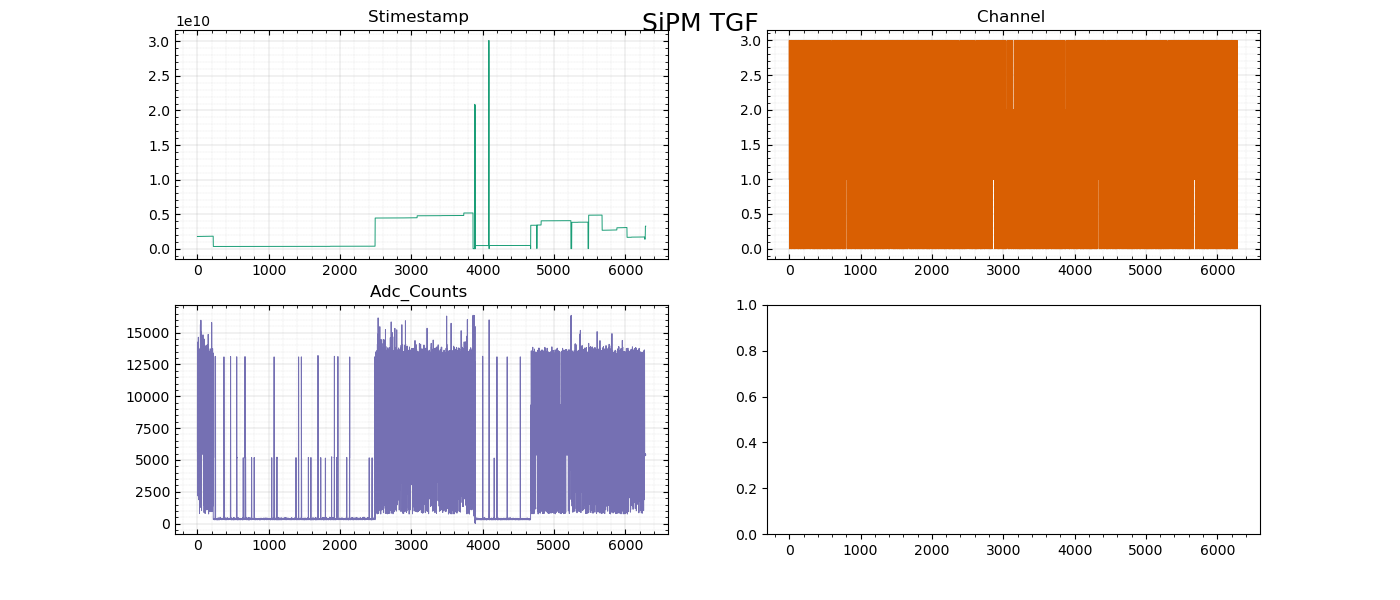

In [5]:
# Plot the TGF Buffer Data

# Plot SiPM
fig, axes = rp.plot_buffer(data_SiPM_tgf,title='SiPM TGF')

Text(0.5, 1.0, 'PMT TGF Energies')

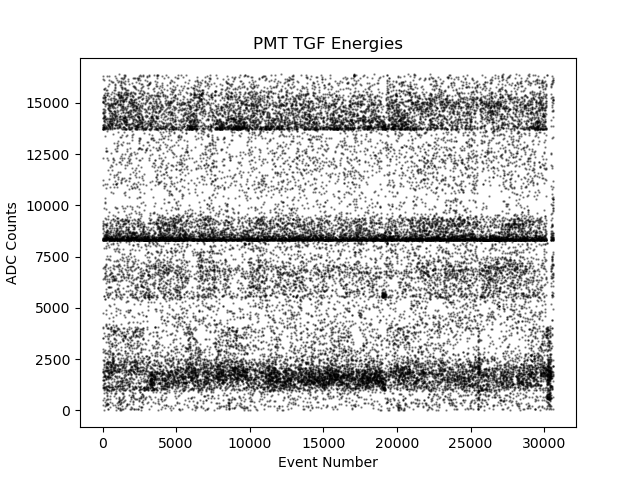

In [6]:
plt.figure()
plt.scatter(list(range(len(data_PMT_tgf['adc_counts']))),data_PMT_tgf['adc_counts'],s=0.5,c='black',alpha=0.4)
plt.xlabel('Event Number')
plt.ylabel('ADC Counts')
plt.title('PMT TGF Energies')

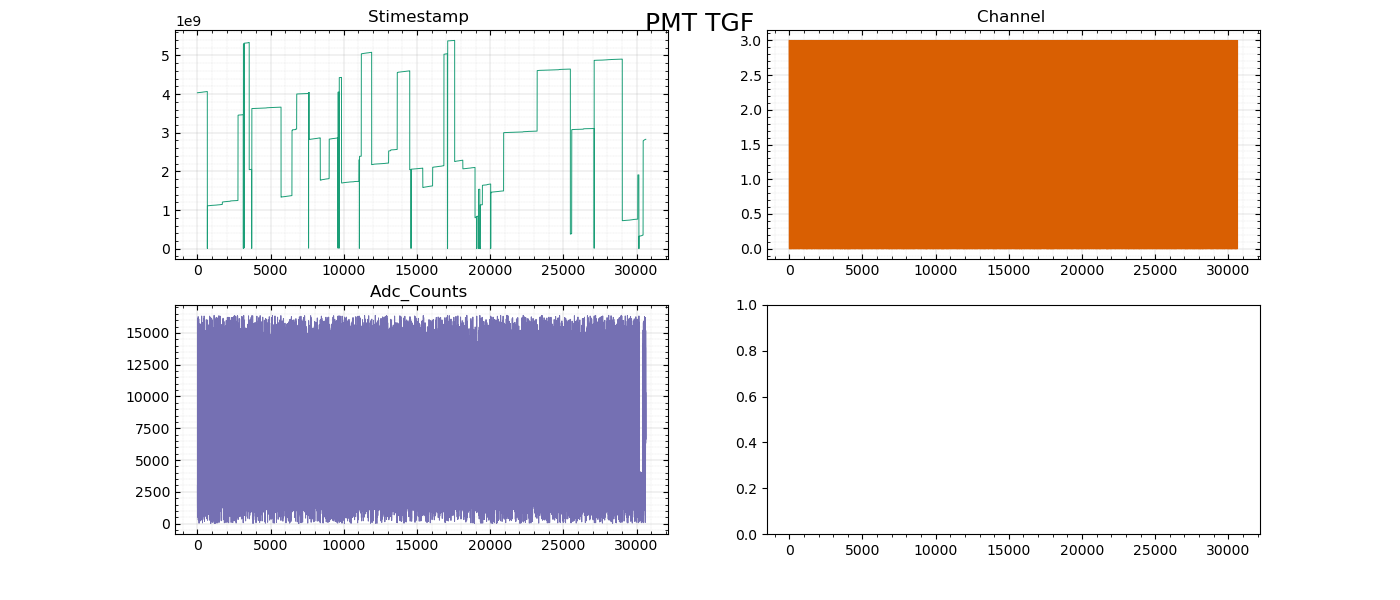

In [7]:
# Plot PMT
fig, axes = rp.plot_buffer(data_PMT_tgf,title='PMT TGF')

In [8]:
# Obtain the coincidence statistics
def get_consecutive_timestamps(data, threshold:float=5e-4, time_units:float=5e-7, VERBOSE=True):
    """Gicen a set of data find the ones that have the same timestamp and return their frequency

    Args:
        data (dict): dataset
        gt (int, optional): Consider only timestamps with more coincidences than this number. Defaults to 0.
        lt (int, optional): Consider only timestamps with less coincidences than this number. Defaults to None.
        VERBOSE (bool, optional): Print statistics if you want to. Defaults to True.

    Returns:
        _type_: _description_
    """
    # Identify the edges
    ramps = rp.get_ramps(data['stimestamp'])

    # list to hold the bunches
    bunches = []

    # For each ramp check if there are nearby data
    for ramp in ramps:

        # The start point of the ramp
        current_bunch = None

        # For each datapoint in the ramp
        for i in range(ramp[0],ramp[1]-1):
            # Check if the neighbors are within the threshold
            if abs(data['stimestamp'][i+1] - data['stimestamp'][i]) < threshold/time_units:
                # If the current bunch is empty then start it
                if current_bunch is None:
                    current_bunch = {
                        'start_idx': i,
                        'cnt': 1
                    }
                # Otherwise simply increase the count
                else:
                    current_bunch['cnt'] += 1
            
            # If the difference is greater than the threshold
            else:
                # If there is no current bunch don't do anything
                if current_bunch is None: continue
                
                # Otherwise finish the bunch and add it
                else:
                    # Add the final data 
                    current_bunch['end_idx']    = i+1
                    current_bunch['cnt']       += 1
                    current_bunch['data']       = rp.dict_subsec(data,range(current_bunch['start_idx'],current_bunch['end_idx']))
                    current_bunch['duration']   = float(max(current_bunch['data']['stimestamp']) - min(current_bunch['data']['stimestamp']))

                    # Add the bunch to the bunches
                    bunches.append(current_bunch)

                    # Reset the bunch
                    current_bunch = None
            
    # # Get the unique times and their frequencies
    # unique_times, unique_freq = np.unique(data['stimestamp'],return_counts=True)

    # # Find the indices where the filters apply
    # idx     = np.where(unique_freq>gt)[0] if lt is None else np.where(lt>unique_freq>gt)[0]

    # # Apply the filters
    # times   = unique_times[idx]
    # freq    = unique_freq[idx]

    # Print if needed
    if VERBOSE:
        print(rp.bcolors.HEADER+"Bunches found:"+rp.bcolors.ENDC+rp.bcolors.BOLD, len(bunches))
        print(rp.bcolors.OKBLUE+'Count'+rp.bcolors.ENDC+rp.bcolors.BOLD+'\tTimestamp'+rp.bcolors.ENDC)
        for bunch in bunches:
            print(rp.bcolors.OKBLUE+"%5d"%bunch['cnt']+rp.bcolors.ENDC+"\t%.1f"%np.mean(bunch['data']['stimestamp']))
            

    return bunches

In [9]:
# obtain the batches of data
batches = get_consecutive_timestamps(data_PMT_tgf,VERBOSE=False)

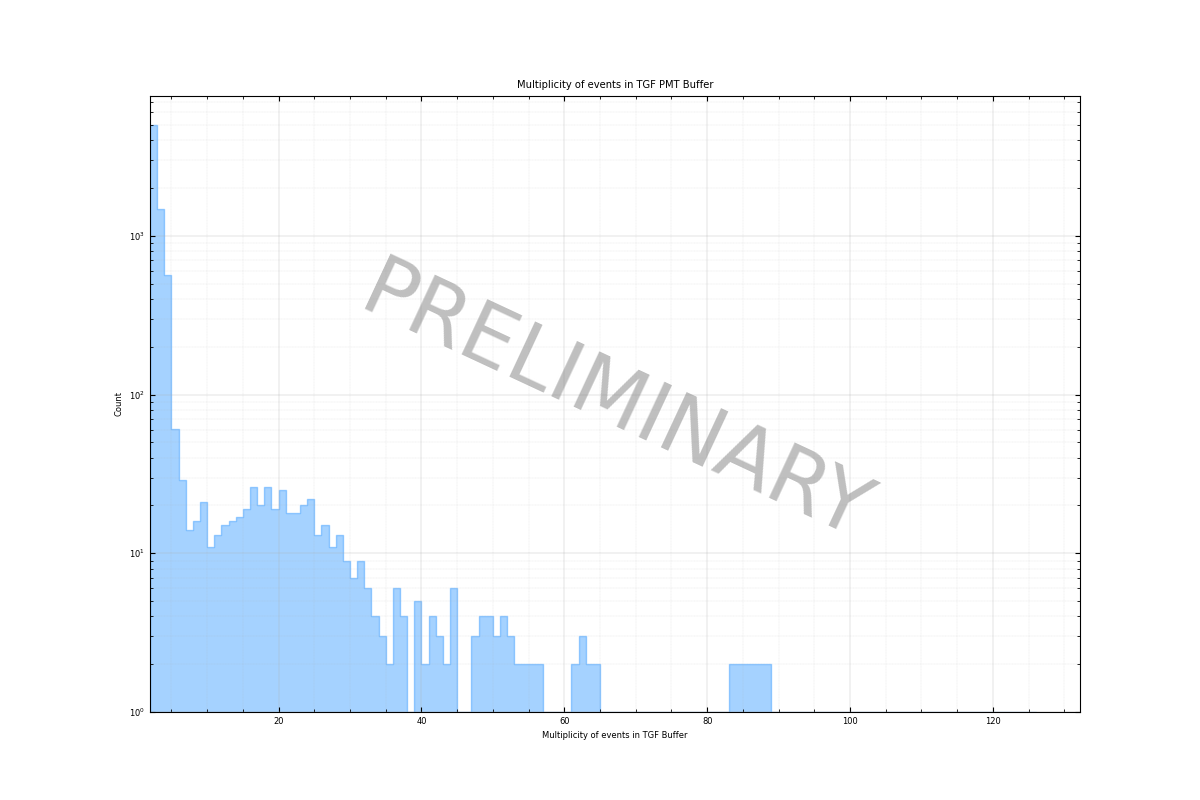

In [14]:
# Plot the batches distribution
def plot_batches(batches):
    # Create a figure
    fig     = plt.figure(figsize=(12,8),dpi=100)
    ax      = fig.add_subplot(111)

    # Get the counts
    counts          = [batch['cnt'] for batch in batches]
    unique, freq    = np.unique(counts, return_counts=True)

    # Plot it as a histogram
    # ax.step(unique,freq,where='post',c='rebeccapurple',lw=0.6,label='Histogram of coincidences')
    ax.fill_between(unique,freq,step="post",alpha = 0.4,color='dodgerblue')

    # Prettify
    ax.set_title('Multiplicity of events in TGF PMT Buffer')
    ax.set_yscale('log')
    ax.set_ylim(1)
    ax.set_xlim(2)
    ax.tick_params(axis='both',which='both',direction='in',top=True,right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(axis='both', which='major', lw=0.25)
    ax.grid(axis='both', which='minor', lw=0.2, ls=':')
    ax.set_xlabel('Multiplicity of events in TGF Buffer')
    ax.set_ylabel('Count')
    # ax.legend(frameon=False)

    # WATERMARK
    ax.text(0.5, 0.5, 'PRELIMINARY', transform=ax.transAxes,
        fontsize=60, color='gray', alpha=0.5,
        ha='center', va='center', rotation='-25')

    return fig,ax

fig,ax = plot_batches(batches)

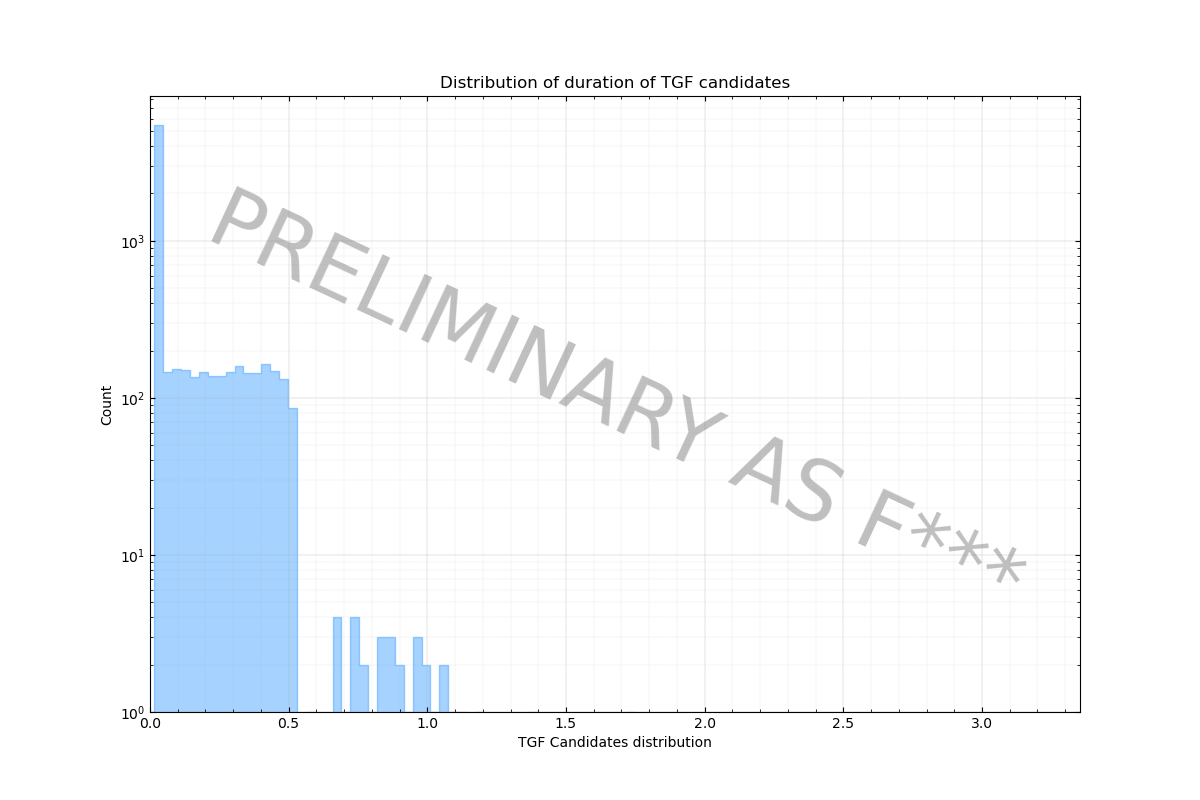

In [11]:
# Plot the batches distribution
def plot_batches_duration(batches):
    # Create a figure
    fig     = plt.figure(figsize=(12,8),dpi=100)
    ax      = fig.add_subplot(111)

    # Get the counts
    times           = [batch['duration']*500e-6 for batch in batches]
    hist, bin_edges = np.histogram(times,bins=100)

    # Plot it as a histogram
    # ax.step((bin_edges[:-1] + bin_edges[1:])/2,hist,where='post',c='rebeccapurple',lw=0.6,label='Histogram of coincidences')
    ax.fill_between((bin_edges[:-1] + bin_edges[1:])/2,hist,step="post",alpha = 0.4,color='dodgerblue')

    # Prettify
    ax.set_title('Distribution of duration of TGF candidates')
    ax.set_yscale('log')
    ax.set_ylim(1)
    ax.set_xlim(0)
    ax.tick_params(axis='both',which='both',direction='in',top=True,right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(axis='both', which='major', lw=0.25)
    ax.grid(axis='both', which='minor', lw=0.2, ls=':')
    ax.set_xlabel('TGF Candidates distribution')
    ax.set_ylabel('Count')
    # ax.legend(frameon=False)

    # WATERMARK
    ax.text(0.5, 0.5, 'PRELIMINARY AS F***', transform=ax.transAxes,
        fontsize=60, color='gray', alpha=0.5,
        ha='center', va='center', rotation='-25')

    return fig,ax

fig,ax = plot_batches_duration(batches)

647


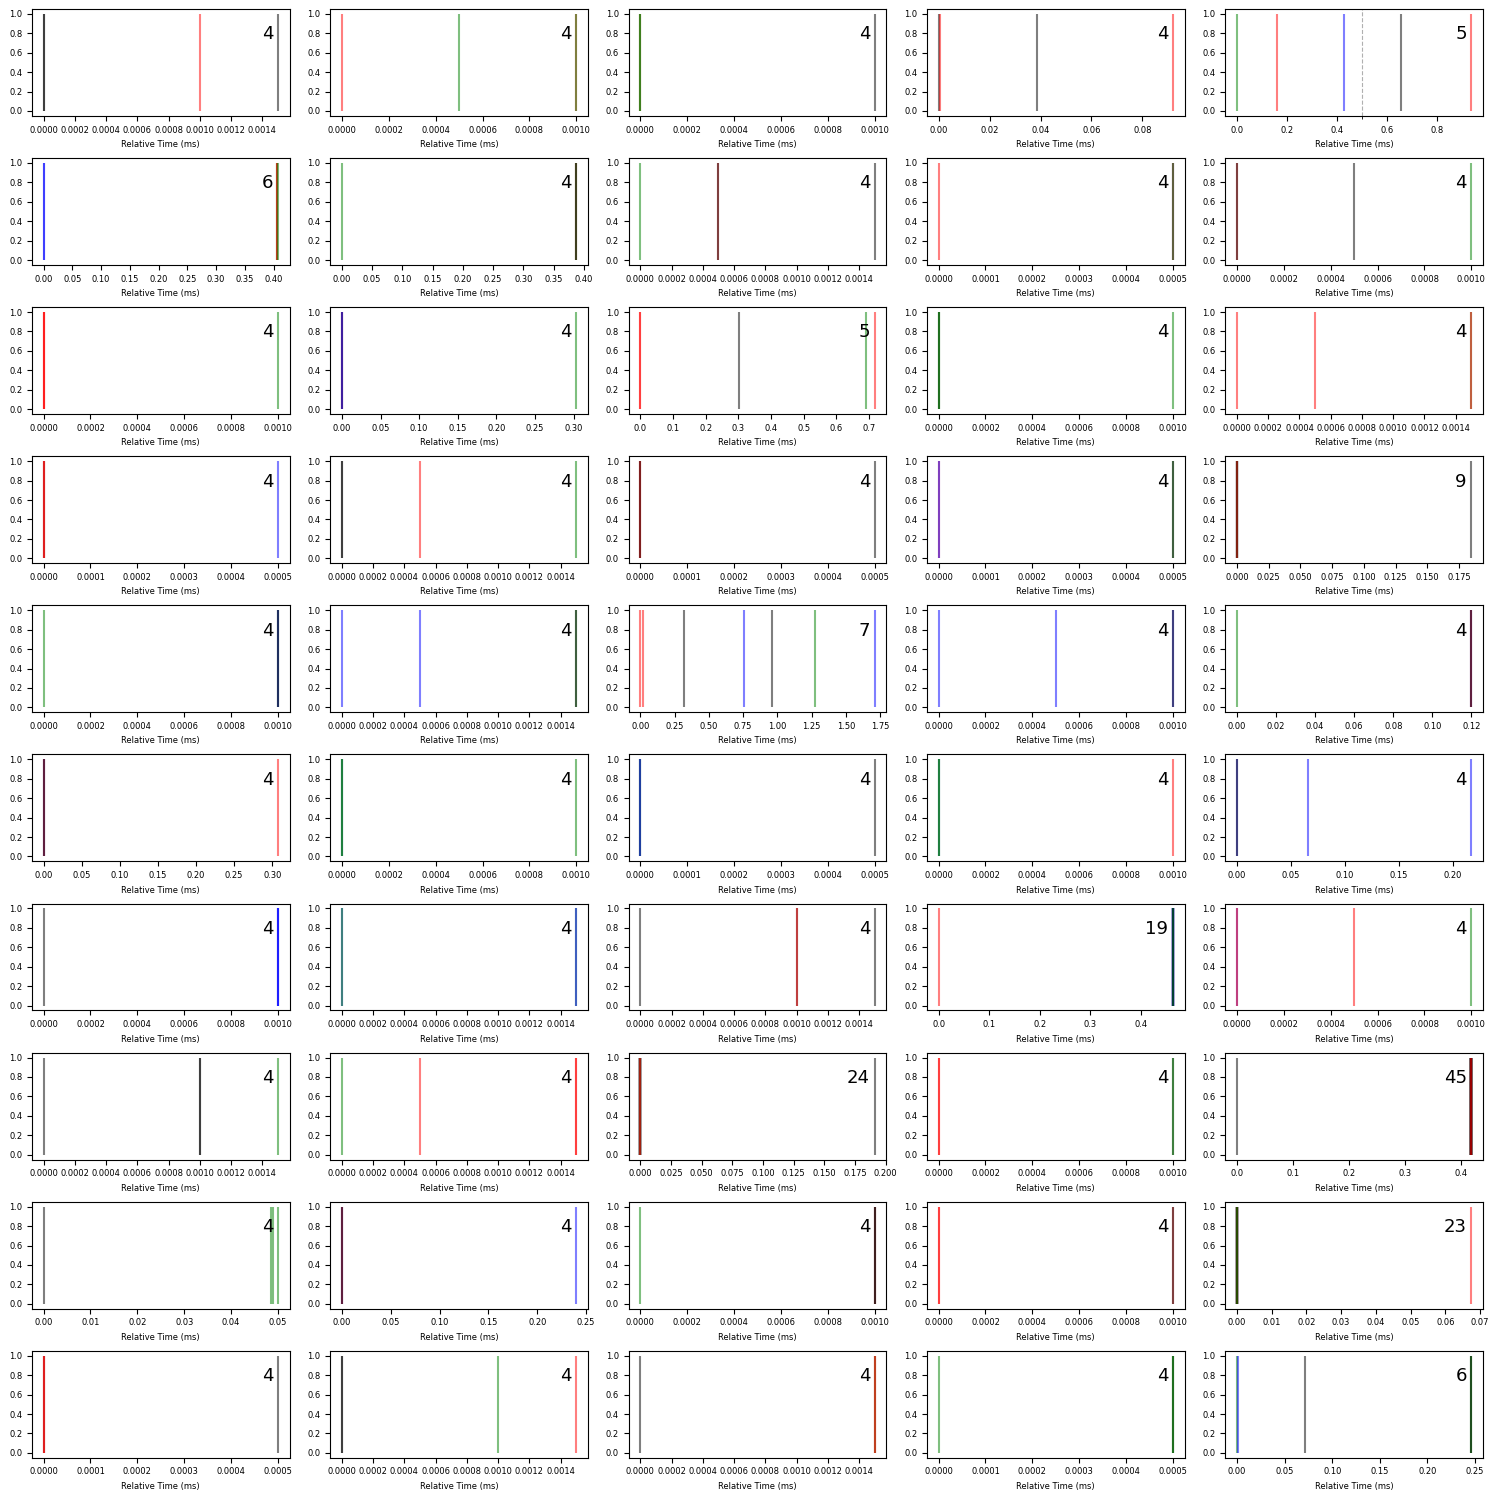

In [17]:
# PARAMETERS
N           = 50
SIZE_X      = 3
SIZE_Y      = 1.5
COLS        = 5
N_THRESHOLD = 3
T_THRESHOLD = 0/500e-6
BIN_WIDTH   = 0.5e-3

# Selected Events
selected = np.array([batch for batch in batches if batch['cnt'] > N_THRESHOLD and batch['duration'] > T_THRESHOLD])
print(len(selected))
if N <= 0: N = len(selected) 
else: selected = np.random.choice(selected, N, replace=False)


# Fix fonts
plt.rcParams.update({'font.size': 6})

# Create a figure
fig, axes = plt.subplots(int(N+COLS/2)//COLS,COLS,figsize=(SIZE_X*COLS,SIZE_Y*(N+COLS/2)//COLS),dpi=100)
fig.subplots_adjust(top=0.95)
axes = axes.flatten()

colors = np.array(['r','g','b','k'])

# Plot each event ont it's own axis
for i,batch in enumerate(selected):

    # Get the data
    timestamps = (batch['data']['stimestamp'] - min(batch['data']['stimestamp']))*500e-6
    channels   = batch['data']['channel']
    energies   = batch['data']['adc_counts']
    
    hist, bin_edges = np.histogram(timestamps,bins=np.arange(min(timestamps), max(timestamps) + BIN_WIDTH, BIN_WIDTH))

    # Plot
    # axes[i].scatter(timestamps,energies,s=10,c='k',marker='x',label='%d'%batch['cnt'])
    axes[i].vlines(timestamps,0,1,color=[colors[int(i)] for i in channels],label='%d'%batch['cnt'],alpha=0.5)
    # axes[i].step((bin_edges[:-1] + bin_edges[1:])/2,hist,where='post',c='k',lw=0.6,label='%d'%batch['cnt'])
    # axes[i].vlines((bin_edges[:-1] + bin_edges[1:])/2,0,hist,color='k',lw=1,label='%d'%batch['cnt'])

    # Prettify
    axes[i].set_xlabel('Relative Time (ms)')
    # axes[i].set_ylabel('Frequency')
    leg = axes[i].legend(frameon=False,handlelength=0, handletextpad=0,fontsize=13)
    for item in leg.legendHandles: item.set_visible(False)
    axes[i].xaxis.set_minor_locator(IndexLocator(base=0.5,offset=0))
    axes[i].grid(which='minor',axis='x',linestyle='--')


plt.tight_layout()

347
2461


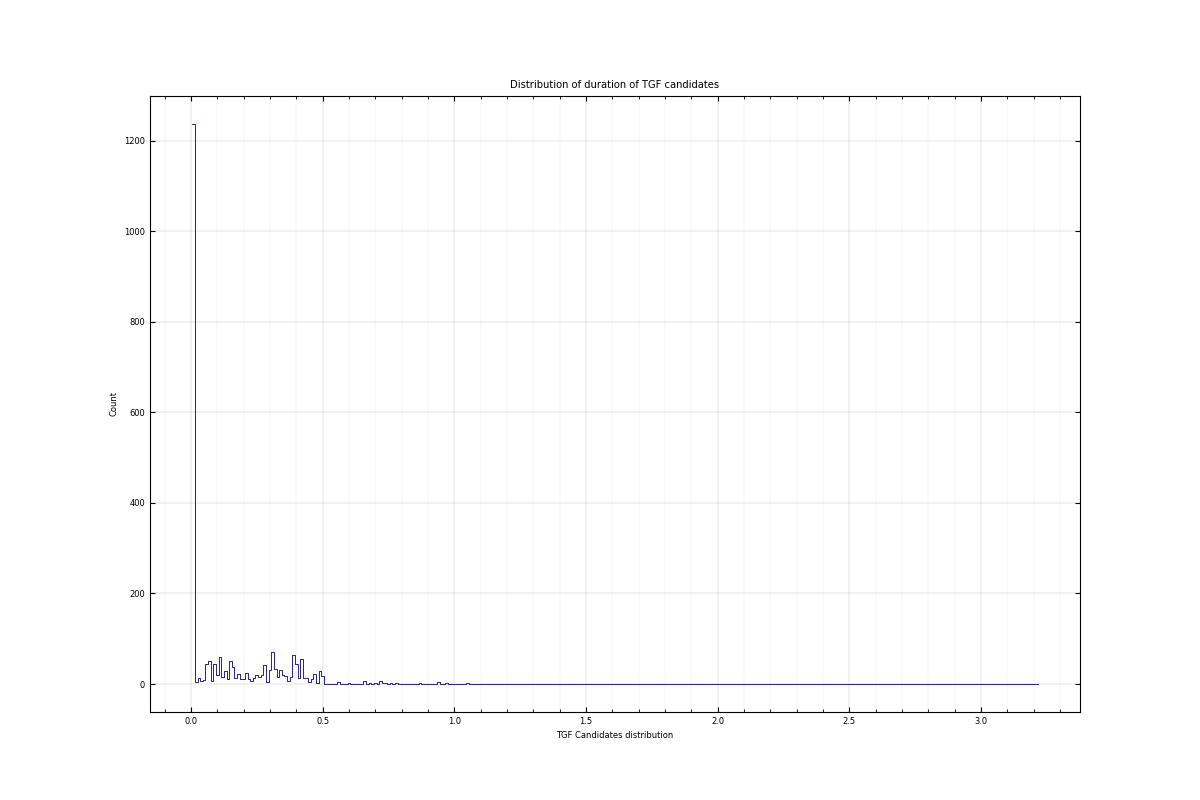

In [16]:
# PARAMETERS
N_THRESHOLD = 0
T_THRESHOLD = 0.01/500e-6
BIN_WIDTH   = 10e-3

# Selected Events
selected = np.array([batch for batch in batches if batch['cnt'] > N_THRESHOLD and batch['duration'] > T_THRESHOLD and len(np.unique(batch['data']['channel'])) >= 3])
print(len(selected))

# Fix fonts
plt.rcParams.update({'font.size': 6})

# Create a figure
fig     = plt.figure(figsize=(12,8),dpi=100)
ax      = fig.add_subplot(111)

timestamps = np.array([])

# Plot each event ont it's own axis
for i,batch in enumerate(selected): 
    timestamps = np.append(timestamps,[(batch['data']['stimestamp'] - min(batch['data']['stimestamp']))*500e-6])

# Get the counts
hist, bin_edges = np.histogram(timestamps,bins=np.arange(min(timestamps), max(timestamps) + BIN_WIDTH, BIN_WIDTH))

# Plot it as a histogram
ax.step((bin_edges[:-1] + bin_edges[1:])/2,hist,where='post',c='darkblue',lw=0.6,label='Histogram of coincidences')

# Prettify
ax.set_title('Distribution of duration of TGF candidates')
# ax.set_yscale('log')
# ax.set_ylim(1)
# ax.set_xlim(2)
ax.tick_params(axis='both',which='both',direction='in',top=True,right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(axis='both', which='major', lw=0.25)
ax.grid(axis='both', which='minor', lw=0.2, ls=':')
ax.set_xlabel('TGF Candidates distribution')
ax.set_ylabel('Count')

print(len(timestamps))